## Basical settings

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder
import multiprocessing
import time
import torch

import utils

plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !nvidia-smi
print(torch.__version__)
print(torch.cuda.is_available())

1.9.1+cu111
True


Global variables

In [3]:
wavelengths     = np.arange(400, 800)*u.nm
FWHM            = 0.5
lambda_Na       = 589.0*u.nm
lambda_Mg       = 518.3*u.nm
width           = 1000
height          = 1500

dir='./dataset/'
os.makedirs(dir, exist_ok=True)

## Generate dataset

Define the function to generate the image. 

In [4]:



def generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                    angle_meteor, length_meteor, angle_slit, length_slit): 
    '''
    function to generate the image. 
    Args: 
        The position of all the stars, the meteor, etc.: 
        coords_stars    [N, 2]      the coordinates of stars plotted in the diagram. Will also give the number of stars
        TODO...
        angle_slit      [0, 2pi)
        angle_meteor    [0, 2pi)
        length_meteor   int         how long the meteor is 
        length_slit     int         how long the track of spectrum is
    Return: 
        one RGB image
    '''
    image_3d = np.zeros([width, height, 400], dtype=np.uint16)           # 0-65536, valid in 0-256 TODO: change to float16? 
    image_3d = utils.add_background(image_3d)
    image_3d = utils.add_stars(image_3d, coord_stars, amp_stars, T_stars)
    image_3d = utils.add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, angle_meteor, length_meteor)
    image_rgb = utils.capture(image_3d, angle_slit, length_slit)
    image_rgb = utils.augmentation(image_rgb)
    # clip the image
    image_rgb = np.clip(image_rgb, 0, 255)# including 0 and 255
    # image_rgb = image_rgb.astype('uint8')
    return image_rgb #image_3d[:,:,0]
    


In [5]:
def generate_dataset(num_images, dir='./dataset/'): 
    '''
    generate the image and save the images in the directory. 
    Args: 
        num_images  
        dir
    Output: 
        JPG files and a json file in COCO format in the directory
    No return
    NOTE: returns an image for testing
    '''
    # TODO: check if the directory is usable
    # customized variables applying to all images
    # TODO: if exception
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    anno_id_start = 1# max([i['id'] for i in labels['annotations']]) + 1
    anno_id = anno_id_start
    image_id_start = 1# max([i['id'] for i in labels['images']]) + 1
    # Loop to generate images
    for image_id in range(image_id_start, image_id_start + num_images): 
        filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
        print('generating image: %s...'%filename)
        # parameters
        num_stars       = 200
        x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # TODO: change the border where the meteor can show
        num_meteors     = 20
        length_meteors  = (np.random.rand(num_meteors)*500).astype(np.int16)                      # pixel
        x_meteors       = (np.random.rand(num_meteors)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_meteors       = (np.random.rand(num_meteors)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # image - parameters needed for `generate_image` function
        coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
        amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
        T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
        coord_meteors   = np.array([x_meteors, y_meteors]).T        # [n, 2]pixel
        amp_meteors     = np.random.rand(num_meteors)*1e8           # [n]erg -> pixel value
        T_meteors       = [2000*u.K]*num_meteors                    # [n]5000K-20000K
        angle_meteors   = np.random.rand(num_meteors)*2*np.pi       # [n]radian
        angle_slit      = np.random.rand()*2*np.pi                  # radian
        length_slit     = 100
        # image
        image = generate_image(coord_stars, amp_stars, T_stars, coord_meteors, amp_meteors, T_meteors, 
                               angle_meteors, length_meteors, angle_slit, length_slit)
        image8 = image.astype(np.uint8)-1
        im = Image.fromarray(image8)
        im.save(os.path.join(dir, filename), quality=100)
        # label - image
        label_image = {
            'license': 1,
            'file_name': filename,
            'height': width,
            'width': height,
            'id': image_id
        }
        labels['images'].append(label_image)
        # label - annotation - meteor
        for [x_meteor, y_meteor], angle_meteor, length_meteor in zip(coord_meteors, angle_meteors, length_meteors):
            label_meteor = utils.annotate_meteor(x_meteor, y_meteor, angle_slit, length_slit, angle_meteor, 
                                                  length_meteor, anno_id, image_id)
            labels['annotations'].append(label_meteor)
            anno_id += 1
        # label - annotation - stars
        for x, y in coord_stars: 
            label_star = utils.annotate_star(x, y, angle_slit, length_slit, anno_id, image_id)
            if label_star != None: 
                labels['annotations'].append(label_star)
                anno_id += 1
        # rewrite json file everytime finishing generating an image
        with open(os.path.join(dir, 'labels.json'), 'w') as f:
            json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    
    return image, labels


Generate the dataset. 

generating image: 1_20230224-192750.jpg...


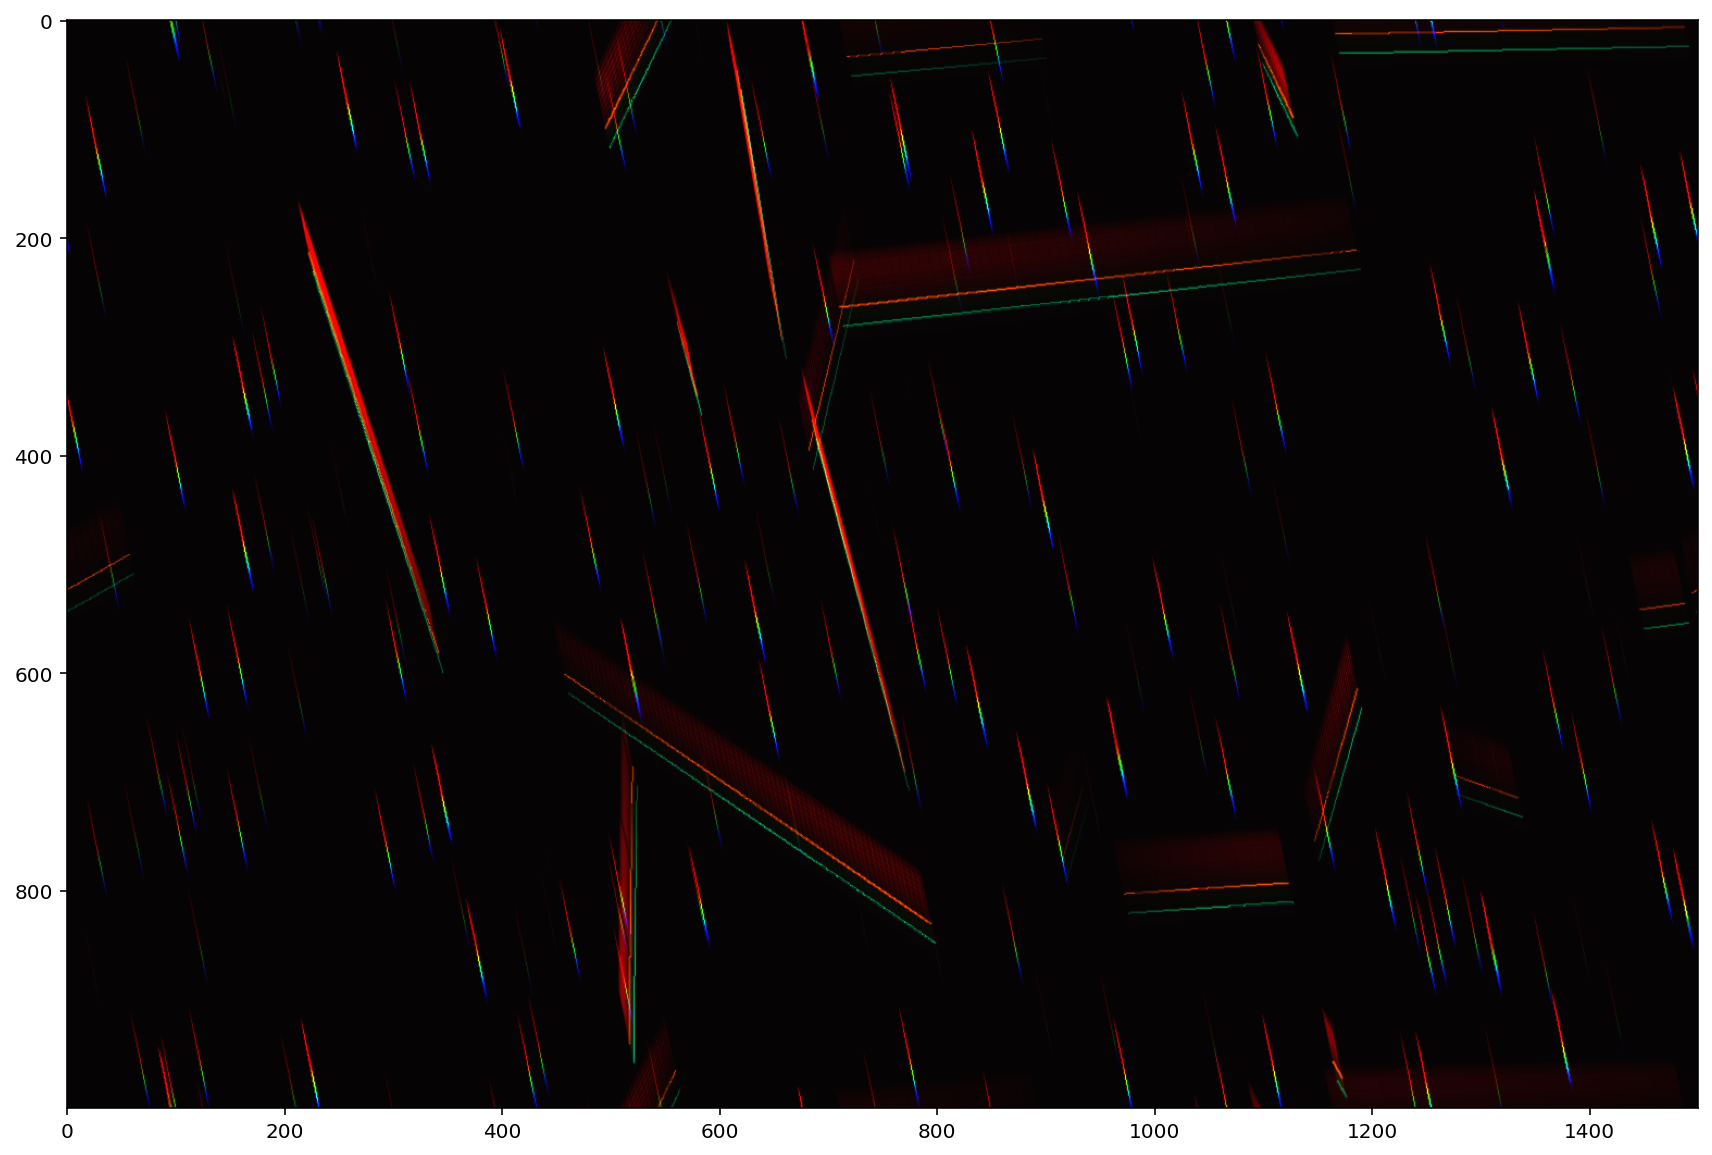

In [6]:
labels = utils.blank_label()
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 1
image, labels = generate_dataset(num_images, dir)

plt.figure(figsize=[15, 10])
plt.imshow(image)

## Register data

Try to read the dataset we have just generated and confirm that the data is correctly loaded and labelled 

In [4]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

dir='./dataset/'

register_coco_instances('fake_meteors', {}, os.path.join(dir, 'labels.json'), dir)
MetadataCatalog.get("fake_meteors").keypoint_names = ['1', '2', '3', '4']
MetadataCatalog.get("fake_meteors").keypoint_flip_map = ()
# del MetadataCatalog.get("fake_meteors").keypoint_connection_rules
MetadataCatalog.get("fake_meteors").keypoint_connection_rules=[('1', '2', (102, 204, 255)), ('3', '4', (255, 195, 77))]

(1000, 1500, 3)


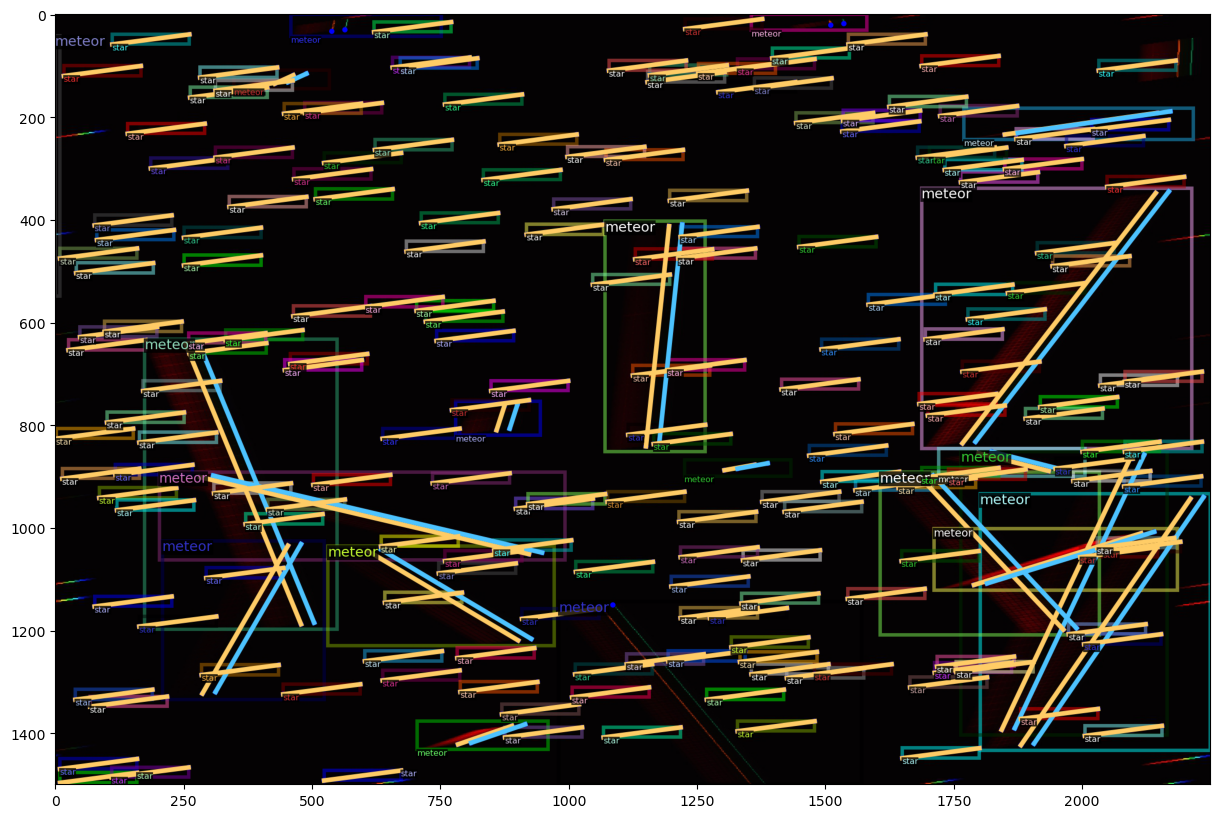

In [5]:

dataset_dicts = DatasetCatalog.get('fake_meteors')
metadata = MetadataCatalog.get('fake_meteors')

for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])


## Train

Using `R50-FPN 3x` model in `COCO Person Keypoint Detection Baselines with Keypoint R-CNN` 

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg

out_dir = './output/'
os.makedirs(out_dir, exist_ok=True)

cfg = get_cfg()

cfg.OUTPUT_DIR = out_dir
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fake_meteors",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)

# del MetadataCatalog.get("fake_meteors").thing_classes
# MetadataCatalog.get("fake_meteors").thing_classes = ['meteor']
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


Transfer learning

In [8]:
# print('Training head')

cfg.MODEL.BACKBONE.FREEZE_AT = 4   # Initial re-training of the head layers (i.e. freeze the backbone)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []          # do not decay learning rate for retraining head layers
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# print('Training full model')

cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze all backbone layers  
cfg.SOLVER.MAX_ITER = 7000          # for LR scheduling
cfg.SOLVER.BASE_LR = 0.001   
cfg.SOLVER.STEPS = [2000,6999]        # decay learning rate
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.MODEL.WEIGHTS = os.path.join(out_dir, 'model_final.pth')  # Initialize from a local weights
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# TODO: print('Saving loss')

# np.save(out_dir+'_losses',trainer.lossList)
# np.save(out_dir+'_val_losses',trainer.vallossList)




[02/14 13:39:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_997cc7.pkl: 313MB [00:06, 45.7MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pred

[02/14 13:39:46 d2.engine.train_loop]: Starting training from iteration 0


/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/14 13:40:00 d2.utils.events]:  eta: 0:33:49  iter: 19  total_loss: 9.474  loss_cls: 0.7617  loss_box_reg: 0.3207  loss_keypoint: 7.437  loss_rpn_cls: 0.4678  loss_rpn_loc: 0.5206  time: 0.6809  data_time: 0.3147  lr: 0.001  max_mem: 5821M
[02/14 13:40:13 d2.utils.events]:  eta: 0:33:27  iter: 39  total_loss: 8.922  loss_cls: 0.6106  loss_box_reg: 0.4003  loss_keypoint: 7.391  loss_rpn_cls: 0.2419  loss_rpn_loc: 0.3459  time: 0.6816  data_time: 0.3013  lr: 0.001  max_mem: 5822M
[02/14 13:40:26 d2.utils.events]:  eta: 0:32:36  iter: 59  total_loss: 8.835  loss_cls: 0.5583  loss_box_reg: 0.434  loss_keypoint: 7.284  loss_rpn_cls: 0.2313  loss_rpn_loc: 0.364  time: 0.6685  data_time: 0.2847  lr: 0.001  max_mem: 5822M
[02/14 13:40:40 d2.utils.events]:  eta: 0:32:31  iter: 79  total_loss: 8.762  loss_cls: 0.5076  loss_box_reg: 0.4224  loss_keypoint: 7.323  loss_rpn_cls: 0.2115  loss_rpn_loc: 0.2946  time: 0.6722  data_time: 0.3051  lr: 0.001  max_mem: 5822M
[02/14 13:40:54 d2.utils.event

/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/14 14:13:35 d2.utils.events]:  eta: 1:39:40  iter: 19  total_loss: 9.066  loss_cls: 0.5483  loss_box_reg: 0.3288  loss_keypoint: 7.237  loss_rpn_cls: 0.526  loss_rpn_loc: 0.3633  time: 0.8554  data_time: 0.3004  lr: 0.001  max_mem: 9916M
[02/14 14:13:52 d2.utils.events]:  eta: 1:39:04  iter: 39  total_loss: 9.084  loss_cls: 0.4901  loss_box_reg: 0.3352  loss_keypoint: 7.368  loss_rpn_cls: 0.4239  loss_rpn_loc: 0.3961  time: 0.8509  data_time: 0.2852  lr: 0.001  max_mem: 9916M
[02/14 14:14:09 d2.utils.events]:  eta: 1:38:29  iter: 59  total_loss: 8.567  loss_cls: 0.3925  loss_box_reg: 0.3012  loss_keypoint: 7.237  loss_rpn_cls: 0.3374  loss_rpn_loc: 0.324  time: 0.8481  data_time: 0.2815  lr: 0.001  max_mem: 9916M
[02/14 14:14:26 d2.utils.events]:  eta: 1:37:59  iter: 79  total_loss: 8.675  loss_cls: 0.3542  loss_box_reg: 0.2836  loss_keypoint: 7.436  loss_rpn_cls: 0.2699  loss_rpn_loc: 0.2572  time: 0.8471  data_time: 0.2842  lr: 0.001  max_mem: 9916M
[02/14 14:14:43 d2.utils.event

learn from zero (test)

In [ ]:
cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze all backbone layers  
cfg.SOLVER.MAX_ITER = 7000          # for LR scheduling
cfg.SOLVER.BASE_LR = 0.00001   
cfg.SOLVER.STEPS = [2000,6999]        # decay learning rate
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0
cfg.MODEL.WEIGHTS = ''
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/14 11:42:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/yl127/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[02/14 11:42:37 d2.utils.events]:  eta: 1:25:14  iter: 19  total_loss: 66.3  loss_cls: 12.37  loss_box_reg: 39.16  loss_keypoint: 13.22  loss_rpn_cls: 1.165  loss_rpn_loc: 6.24  time: 0.7313  data_time: 0.3035  lr: 1e-05  max_mem: 10540M
[02/14 11:42:52 d2.utils.events]:  eta: 1:26:29  iter: 39  total_loss: 10.69  loss_cls: 0.8182  loss_box_reg: 0.6134  loss_keypoint: 7.962  loss_rpn_cls: 0.6957  loss_rpn_loc: 0.5782  time: 0.7464  data_time: 0.3117  lr: 1e-05  max_mem: 10540M
[02/14 11:43:08 d2.utils.events]:  eta: 1:27:00  iter: 59  total_loss: 9.899  loss_cls: 0.5383  loss_box_reg: 0.1337  loss_keypoint: 7.975  loss_rpn_cls: 0.696  loss_rpn_loc: 0.5548  time: 0.7534  data_time: 0.3114  lr: 1e-05  max_mem: 10540M
[02/14 11:43:23 d2.utils.events]:  eta: 1:27:12  iter: 79  total_loss: 9.886  loss_cls: 0.5315  loss_box_reg: 0.1158  loss_keypoint: 7.98  loss_rpn_cls: 0.6933  loss_rpn_loc: 0.4534  time: 0.7549  data_time: 0.3077  lr: 1e-05  max_mem: 10540M
[02/14 11:43:38 d2.utils.events]

# Evaluation

See how it works in our validation dataset (TODO) and the real image

Reference of the real image: `2021JIMO...49...71Z`

[02/14 15:53:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


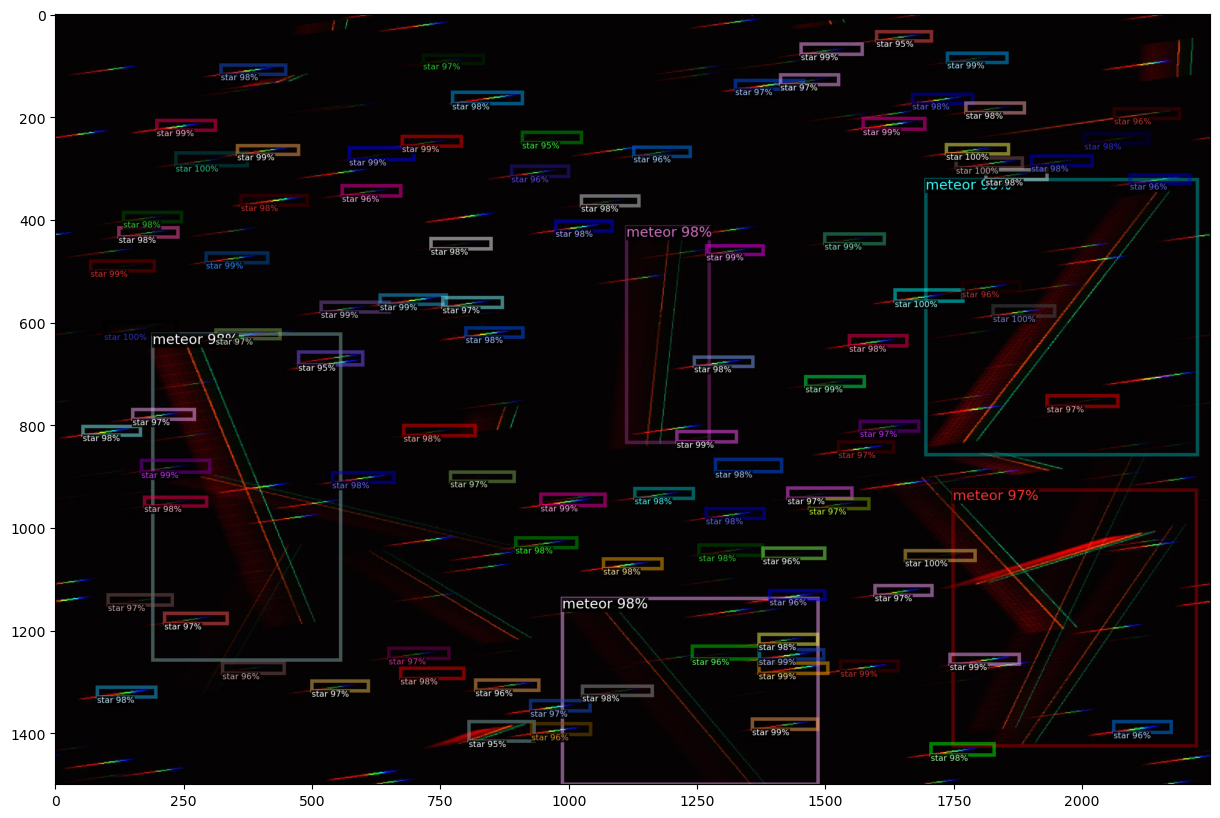

In [9]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(out_dir, 'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0

# for d in random.sample(dataset_dicts, 1):    
im = plt.imread(d["file_name"])
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], metadata, scale=1.5)
# print(outputs["instances"])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=[15, 10])
plt.imshow(out.get_image()[:, :, ::-1])

[02/14 16:55:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


[02/14 16:55:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/yl127/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


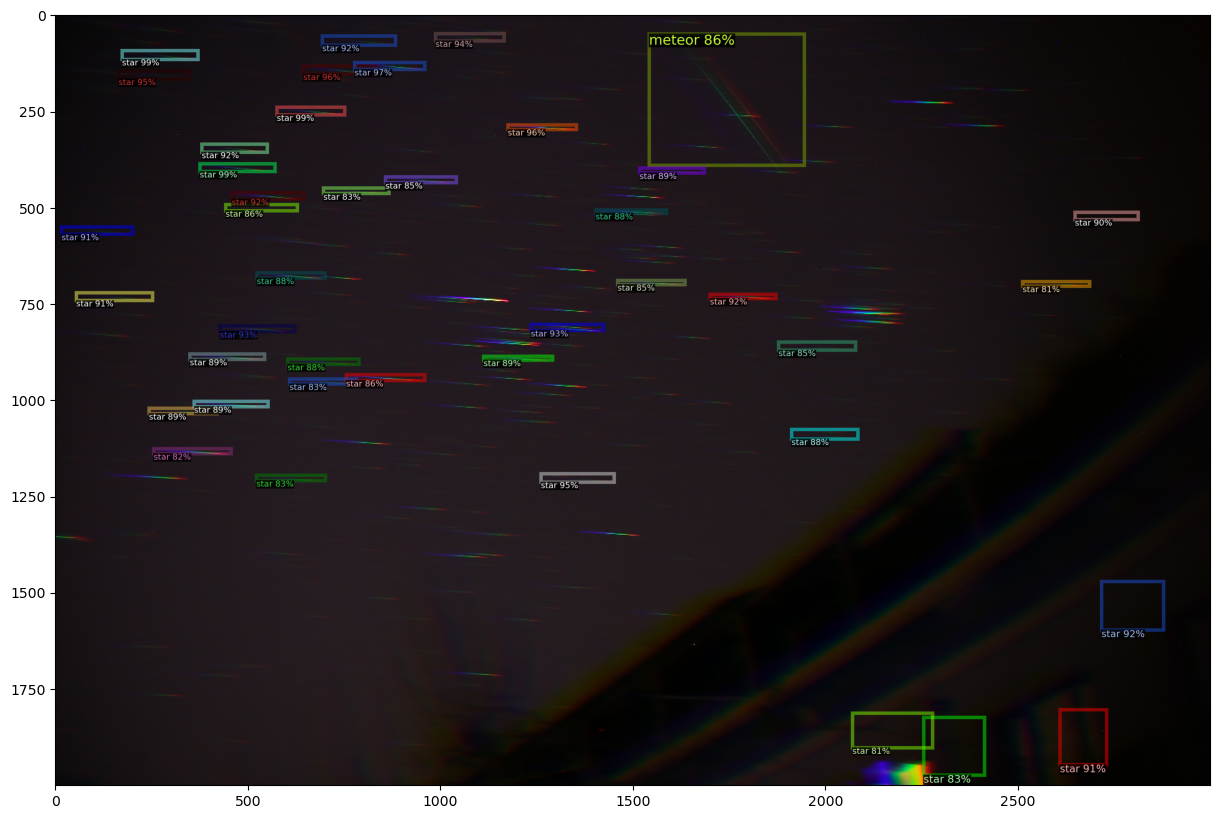

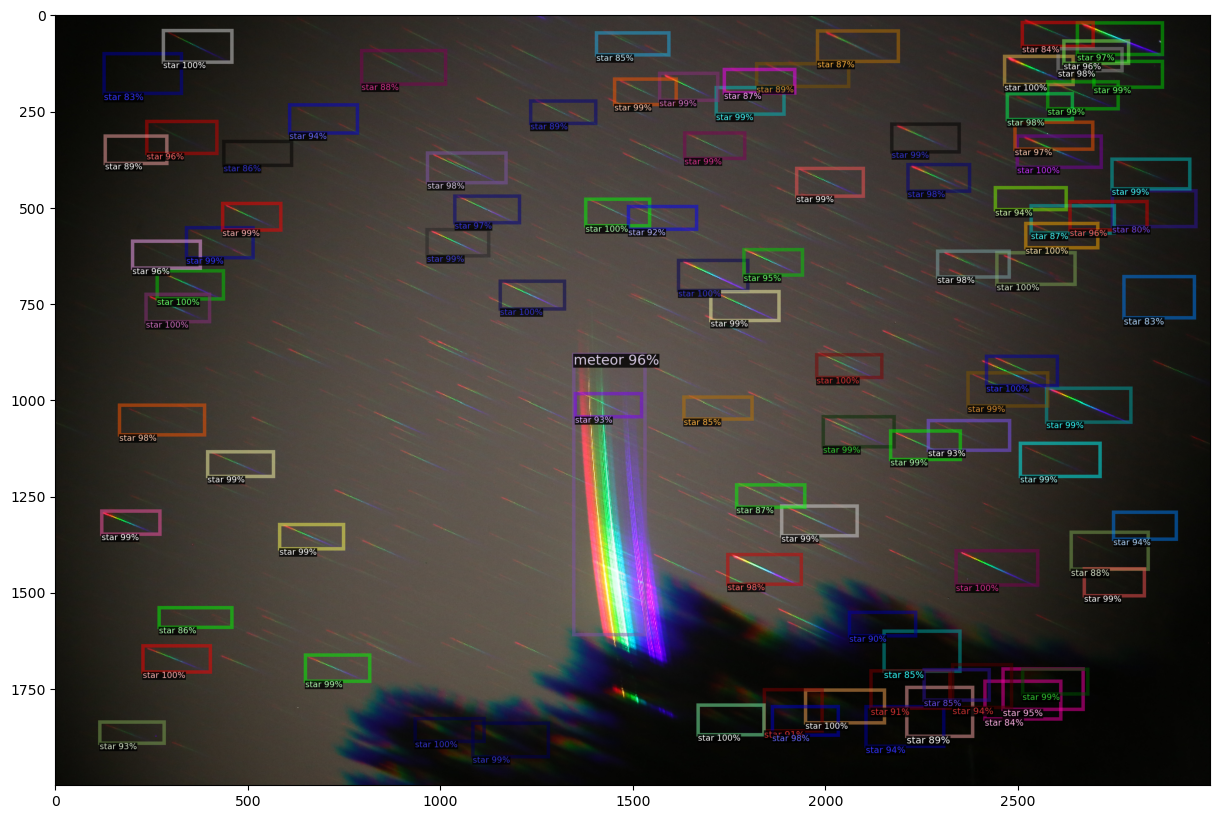

In [11]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
del MetadataCatalog.get("fake_meteors").keypoint_names
MetadataCatalog.get("fake_meteors").keypoint_names = ['1', '2', '3', '4']

for im in [plt.imread("testimg2.jpg"), plt.imread("testimg.jpg")]:
    im = cv2.resize(im, dsize=(1500, 1000), interpolation=cv2.INTER_CUBIC)
    # print(im.shape, im.dtype)
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])